In [46]:
#!pip3 install pandas
from pandas import read_csv
filename = "take_home_data.csv"
data = read_csv(filename, header=0)
print(data.shape)

#peek data
peek = data.head(10)
#print(peek)

#data type
types = data.dtypes
#print(types)

(10000, 15)


In [47]:
#format methods
#!pip3 install phonenumbers
import phonenumbers
import pandas as pd
from datetime import datetime
import re
import requests 

def format_phoneNumber(number):
    #assume the default Country Code is US, so the size of digtit should bigger than 10
    if pd.isnull(number):
        return "ERROR({})".format(number)
    try:
        size = 0
        for c in number:
            if c.isdigit():
                size = size + 1
        if size < 10:
            return "ERROR({})".format(number)
        phone = phonenumbers.parse(number, "US")
        return phonenumbers.format_number(phone, phonenumbers.PhoneNumberFormat.INTERNATIONAL)
    except:
        #print("Error happens for number: {}".format(number))
        return "ERROR({})".format(number)

def format_dateTime(date):
    if pd.isnull(date):
        return "ERROR({})".format(date)
    formats = ['%m/%d/%y %H:%M', '%m/%d/%Y %H:%M', '%m/%d/%y', '%m/%d/%Y']
    for f in formats:
        try:
            return datetime.strptime(date, f).strftime("%m/%d/%Y %H:%M")
        except:
            #print("exceptions for {}".format(date))
            pass
    return "ERROR({})".format(date)

def email_check(email):
    if pd.isnull(email):
        return ""
    reg = r"(^[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+$)"
    if re.match(reg, email):
        return str(email)
    else:
        print(email)
        return "ERROR({})".format(email)
    
def format_address(query):
    #use openstreetmap to do address validation, if you have Google Maps API key, you can also use Google Maps API
    URL = "https://nominatim.openstreetmap.org/?format=json&addressdetails=1&format=json&limit=2&country=United%20States%20of%20America"
    #street=<housenumber> <streetname>
    #city=<city>
    #county=<county>
    #state=<state>
    #country=<country>
    #postalcode=<postalcode>
#     PARAMS = {k:v for k,v in query.items()}
    result = {"road" : "", "city" : "", "county" : "", "state" : "", "postcode" : ""}
    try:
        r = requests.get(url = URL, params = query)
        data = r.json()
        if len(data) == 0:
            result["status"] = False
            return result
        try:
            result['lat'] = data[0]['lat']
            result['lon'] = data[0]['lon']
        except:
            #do nothing
            pass
        for k,v in result.items():
            try:
                result[k] = data[0]['address'][k]
            except:
                #do nothing
                pass
        result["status"] = True
        return result
    except:
        result["status"] = False
        return result

def address_validation(street, city, state, postalcode):
    #if postalcode length less than 5, assume wrong, will try to fix it later
    lat = ''
    lon = ''
    if pd.isnull(postalcode) or len(str(postalcode)) < 5:
        postalcode = "ERROR({})".format(postalcode)
    #check state first, in order to speed up, we assume state is right
#     result = format_address({"state":state})
    if pd.isnull(state):
        #if state wrong, we can assume the address is wrong, 
        #TODO: we can find out most close state and give suggestion
        return street, city, "ERROR({})".format(state), postalcode, lat, lon
    
    if pd.isnull(city):
        city = "ERROR({})".format(city)
    if pd.isnull(street):
        return "ERROR({})".format(street), city, state, postalcode, lat, lon
    
    result = format_address({"street":street, "state":state})
    if result["status"]:
        
        if result["city"] != city and not pd.isnull(result["city"]) and result["city"] != '':
            city = "UPDATE(F({}),T({}))".format(city,result["city"])
        if not pd.isnull(result["postcode"]) and str(result["postcode"]) not in str(postalcode) :
            postalcode = "UPDATE(F({}),T({}))".format(postalcode,result["postcode"])
        return street, city, state, postalcode, result["lat"], result["lon"]
    else:
        return "ERROR({})".format(street), city, state, postalcode, lat, lon
    
#same test for address_validation


def simple_address_validation(street, city, state, postalcode):
    if pd.isnull(postalcode) or len(str(postalcode)) < 5:
        postalcode = "ERROR({})".format(postalcode)
    if pd.isnull(street) :
        street = "ERROR({})".format(street)
    if pd.isnull(city) :
        street = "ERROR({})".format(city)
    if pd.isnull(state) :
        street = "ERROR({})".format(state)
    return street, city, state, postalcode

In [ ]:
print(address_validation('3029 lowrey ave', 'Bentonville','Hawaii','97655'))
#wrong city and wrong zip code
#will get result as 
#('3029 lowrey ave', 'UPDATE(F(Bentonville),T(Honolulu))', 'Hawaii', 'UPDATE(F(97655),T(96822))', '21.308664251275', '-157.807035707976')

gis = []
for index, row in data.iterrows():
    row["phone"] = format_phoneNumber(row["phone"])
    row["work phone"] = format_phoneNumber(row["work phone"])
    row["account created on"] = format_dateTime(row["account created on"])
    row["email"] = email_check(row["email"])
    row["work email"] = email_check(row["work email"])
    
    #while I try to run the fowlloing code, I got an error as "Bandwidth limit exceeded, You have been temporarily blocked because you have been overusing OSM's geocoding service"
#     row["address"], row["city"], row["state"], row["zip"], lat, lon = address_validation(row["address"], row["city"], row["state"], row["zip"])
#     if lat != '':
#         gis.append([lat,lon])
#     row["work address"], row["work city"], row["work state"], row["work zipcode"], lat, lon = address_validation(row["work address"], row["work city"], row["work state"], row["work zipcode"])
    #just simply validation
    row["address"], row["city"], row["state"], row["zip"] = simple_address_validation(row["address"], row["city"], row["state"], row["zip"])
    row["work address"], row["work city"], row["work state"], row["work zipcode"] = simple_address_validation(row["work address"], row["work city"], row["work state"], row["work zipcode"])

#save result
data.to_csv (r'Modified_data.csv', index = None, header=True)
pd.DataFrame(gis).to_csv (r'gis.csv', index = None, header=True)

('3029 lowrey ave', 'UPDATE(F(Bentonville),T(Honolulu))', 'Hawaii', 'UPDATE(F(97655),T(96822))', '21.308664251275', '-157.807035707976')
0
100
200
jacob14_at_yu.biz
skennedy@king-jonesinfo
9f209834sjl
300
400
500


In [43]:
# get ERROR distribution by column
from collections import Counter
import pandas as pd
cnt = Counter()
for column in data.columns:
    for v in data[:][column]:
        if 'ERROR' in str(v):
            cnt[column] += 1
print(cnt)
pd.DataFrame.from_dict(cnt, orient='index').reset_index().rename(columns={'index':'columnName', 0:'count'}).to_csv (r'Error_count_distribution_by_columns.csv', index = None, header=True)

Counter({'work zipcode': 569, 'zip': 514, 'phone': 270, 'work phone': 247, 'address': 81, 'work address': 79, 'account created on': 56, 'work email': 4})


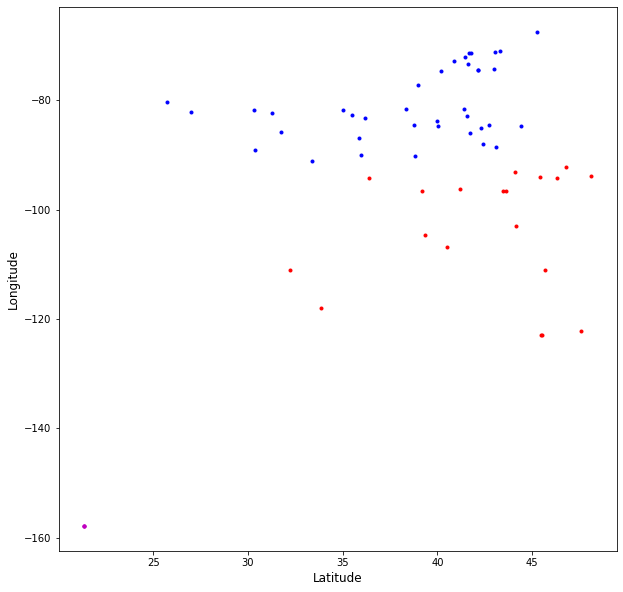

In [12]:
#use K-means to group the Geospatial data
#because of OSM API restriction, I just get about 100 rows of data.
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
from matplotlib import pyplot
from pandas import read_csv
import matplotlib.pyplot as plt

X = read_csv("gis_500.csv")
X.columns = ['latitude', 'longitude']

id_n=3
kmeans = KMeans(n_clusters=id_n, random_state=0).fit(X)
id_label=kmeans.labels_

#plot result
ptsymb = np.array(['b.','r.','m.','g.','c.','k.','b*','r*','m*','r^']);
plt.figure(figsize=(12,12))
plt.ylabel('Longitude', fontsize=12)
plt.xlabel('Latitude', fontsize=12)
for i in range(id_n):
    cluster=np.where(id_label==i)[0]
    plt.plot(X.latitude[cluster].values,X.longitude[cluster].values,ptsymb[i])
# plt.show()
fig = pyplot.gcf()
fig.set_size_inches(10, 10)
fig.savefig('K-means_clustering_result.png', dpi=100)

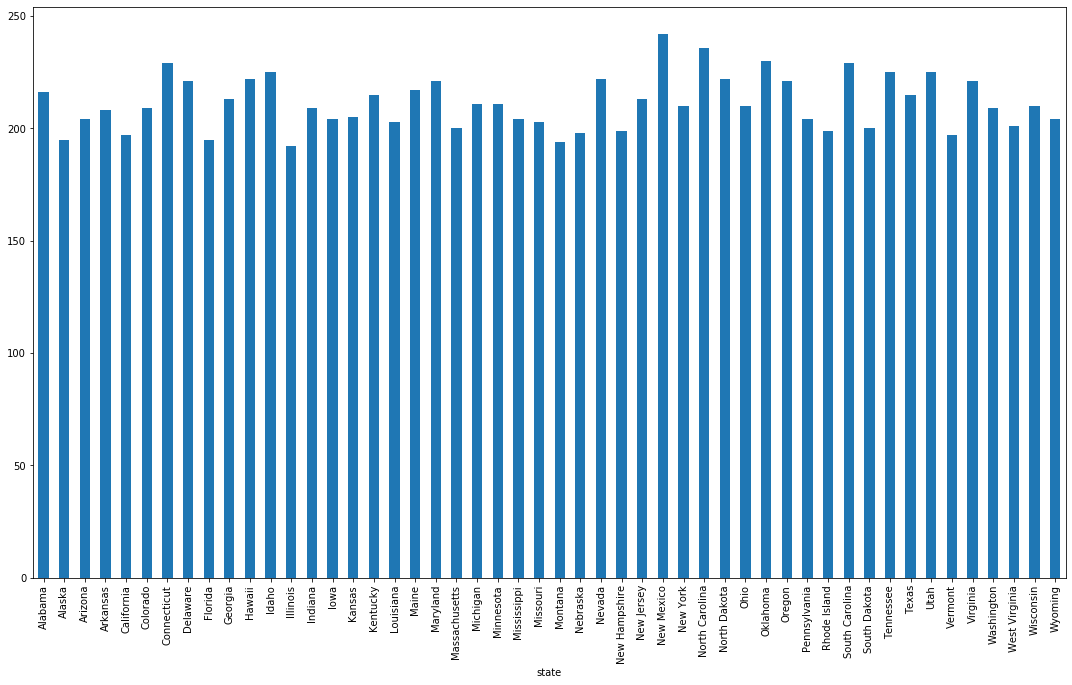

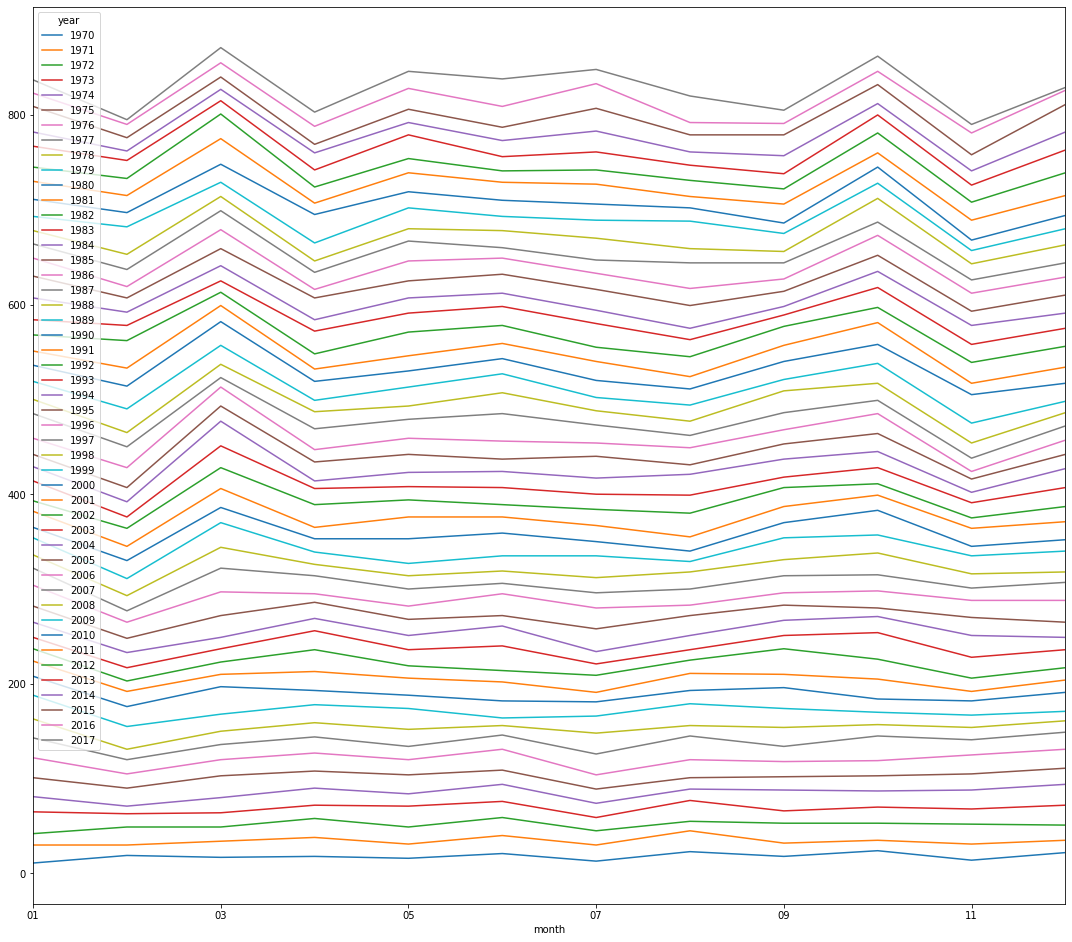

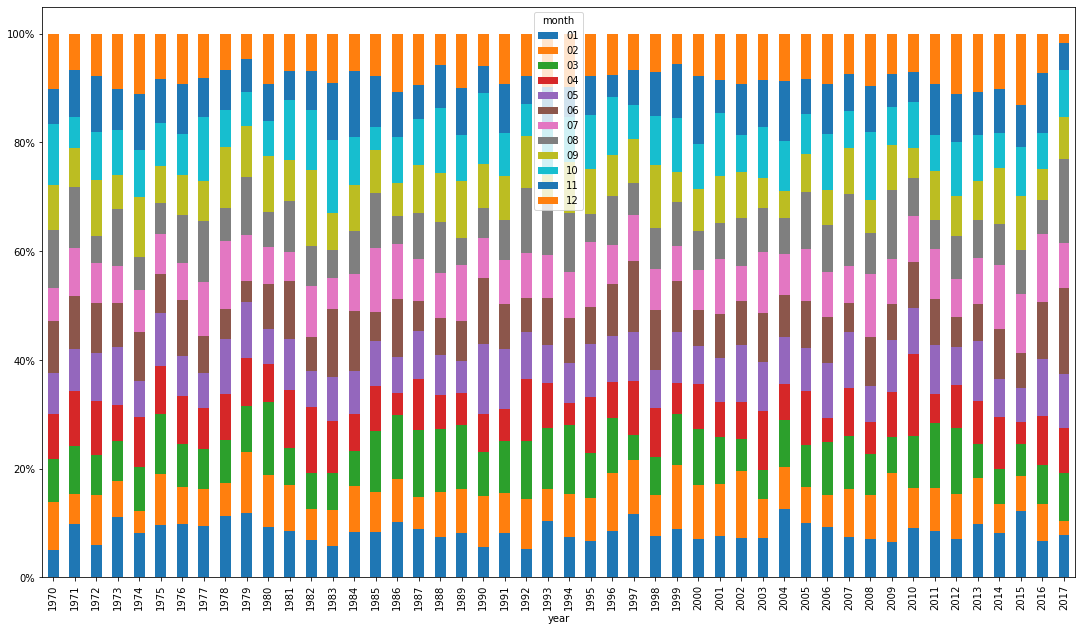

In [45]:
#!pip3 install matplotlib
#!pip3 install scipy
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.pyplot import figure

# figure(num=None, figsize=(18, 16), dpi=80, facecolor='w', edgecolor='k')

# fig.savefig('test2png.png', dpi=100)
#data group by
years = pd.DataFrame([z[6:10] for z in data[:]["account created on"] if z[0:5] != 'ERROR' and z != ''])
years.columns = ['year']

count_by_year = years.groupby('year')['year'].size()
count_by_year.plot(kind='bar',layout=(1,1))
fig = pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
fig.savefig('count_by_year.png', dpi=100)

states = pd.DataFrame([z for z in data[:]["state"]])
states.columns = ['state']

states.groupby('state')['state'].size().plot(kind='bar',layout=(1,1))
fig = pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
fig.savefig('count_by_state.png', dpi=100)


year_months = pd.DataFrame([[z[6:10], z[0:2]] for z in data[:]["account created on"] if z[0:5] != 'ERROR' and z != ''])
year_months.columns = ['year','month']
count_by_year_month = year_months.groupby(by=['month','year']).size().unstack().plot(kind='line',stacked=True)
fig = pyplot.gcf()
fig.set_size_inches(18.5, 16.5)
fig.savefig('count_by_month_year.png', dpi=100)
# count_by_year_month.plot(kind='bar',layout=(1,1))
# plt.savefig('count_by_year_month.png')

year_months.groupby(['year','month']).size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()
).unstack().plot(kind='bar',stacked=True)

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
fig = pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
fig.savefig('count_by_year_month_normalized.png', dpi=100)

#count by zip
zips = pd.DataFrame([z[0:5] for z in data[:]["zip"] if len(str(z)) >= 5])
count_by_zipcode = zips.groupby(by=0).size()
# print(count_by_zipcode)

LR: -234.18719 (124.91008)
ARD: -189.44268 (73.54830)
Ridge: -216.74347 (101.92288)
LASSO: -228.18383 (115.72198)
EN: -229.92905 (118.44471)
KNN: -239.23333 (103.97036)
CART: -341.66667 (115.48122)
SVR: -215.03100 (97.73163)
AB: -227.53798 (115.25163)
GBM: -285.90392 (132.31652)
RF: -196.98933 (73.24648)
ET: -240.15367 (146.43883)
SLR: -234.18719 (124.91008)
SARD: -189.09380 (73.40765)
SRidge: -216.30436 (100.98393)
SLASSO: -192.82179 (80.49661)
SEN: -203.30771 (90.33100)
SKNN: -256.09600 (105.35437)
SCART: -354.16667 (125.90969)
SSVR: -215.06991 (96.19203)
SAB: -247.79219 (167.02268)
SGBM: -296.19474 (154.44140)
SRF: -222.12633 (128.42040)
SET: -267.18067 (216.53504)
ARDRegression(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
              fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
              normalize=False, threshold_lambda=10000.0, tol=0.001,
              verbose=False)
The data for 2018: [217.80519614]


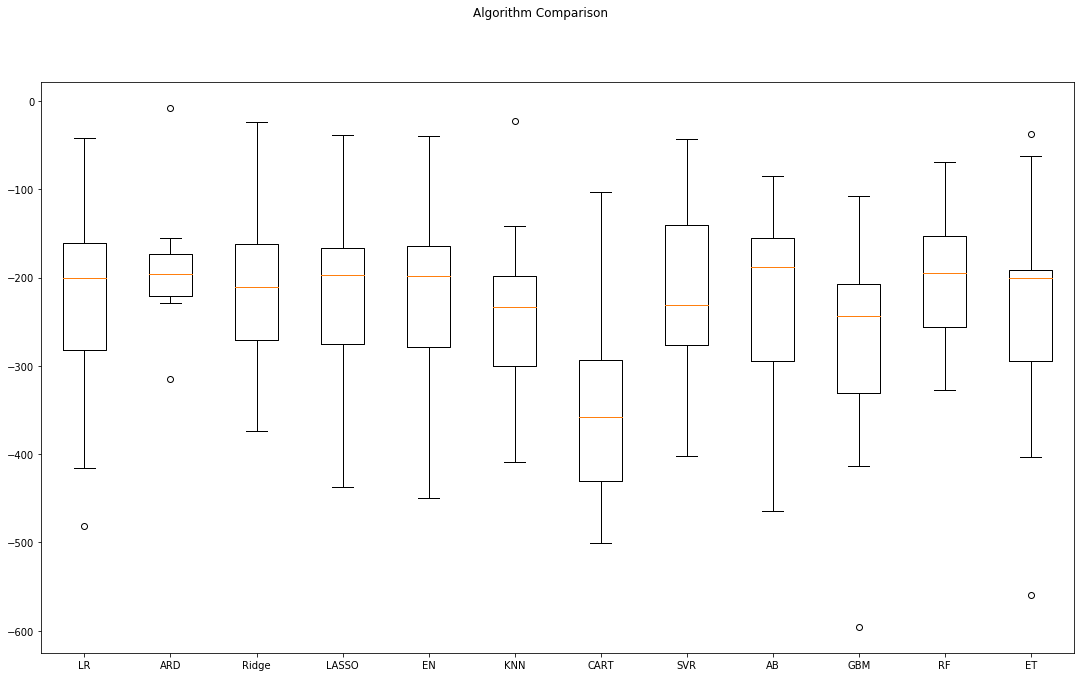

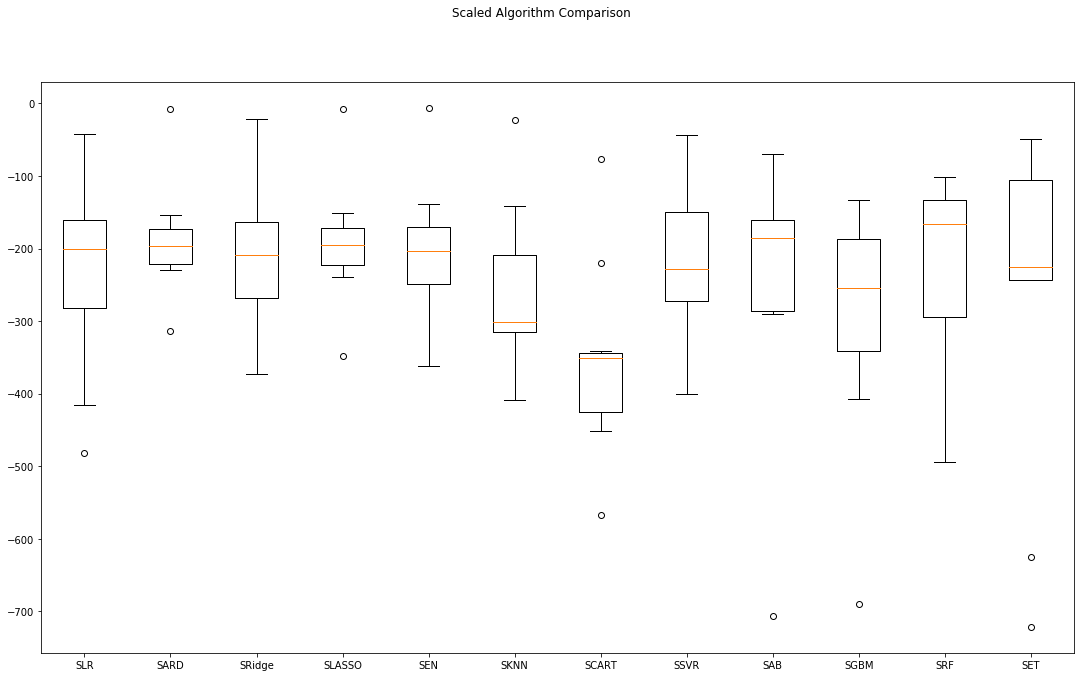

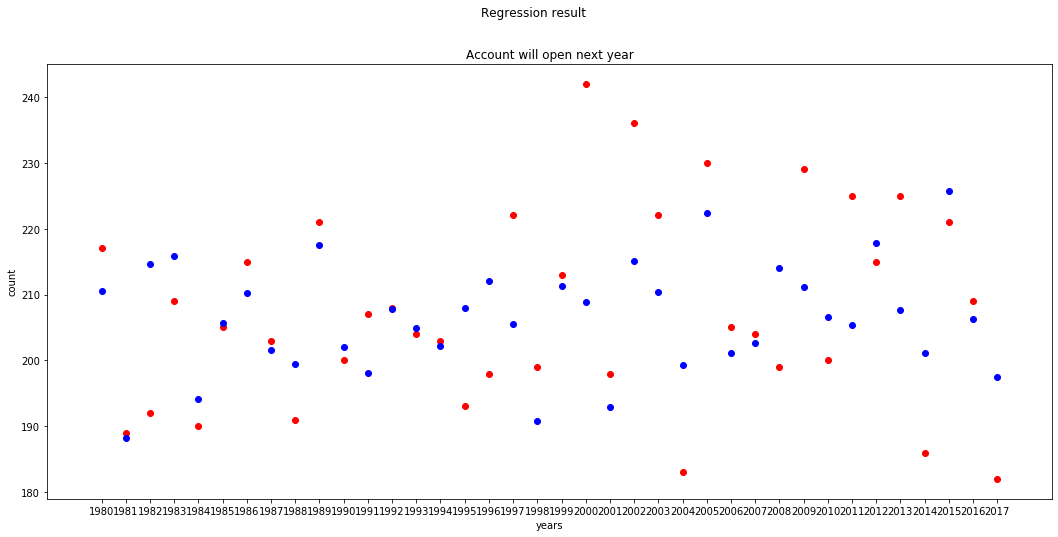

In [38]:
#use mechine learning algorithms to do time series regression
#!pip3 install sklearn
# Load libraries
# Load libraries
import numpy as np
from numpy import arange
from matplotlib import pyplot
from pandas import read_csv
from pandas import set_option
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ARDRegression
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
ts_data = np.array(count_by_year)
#use last 10 years data to predict the next year's data
X = np.array([ts_data[i:i+10] for i in range(0,len(ts_data)-10)])
Y = np.array([ts_data[i] for i in range(10,len(ts_data))])

# Split-out validation dataset
validation_size = 0.20
seed = 7
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y,
    test_size=validation_size, random_state=seed)
# Test options and evaluation metric
num_folds = 10
seed = 7
scoring =  'neg_mean_squared_error'
# Spot-Check Algorithms
models = []
models.append(( 'LR' , LinearRegression()))
models.append(( 'ARD' , ARDRegression()))
models.append(( 'Ridge' , BayesianRidge()))

models.append(( 'LASSO' , Lasso()))
models.append(( 'EN' , ElasticNet()))
models.append(( 'KNN' , KNeighborsRegressor()))
models.append(( 'CART' , DecisionTreeRegressor()))
models.append(( 'SVR' , SVR()))

models.append(( 'AB' , AdaBoostRegressor()))
models.append(( 'GBM' ,GradientBoostingRegressor()))
models.append(( 'RF' ,RandomForestRegressor()))
models.append(( 'ET' , ExtraTreesRegressor()))
# evaluate each model in turn
results = []
names = []
for name, model in models:
  kfold = KFold(n_splits=num_folds, random_state=seed)
  cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "{}: {:3.5f} ({:3.5f})".format(name, cv_results.mean(), cv_results.std())
  print(msg)
    
# Compare Algorithms
fig = pyplot.figure()
fig.suptitle( 'Algorithm Comparison' )
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
# pyplot.savefig("Algorithm Comparison.png")
fig = pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
fig.savefig('Algorithm Comparison.png', dpi=100)

# try to Standardize the dataset to see is there performance improve
pipelines = []
pipelines.append(( 'SLR' , Pipeline([( 'Scaler' , StandardScaler()),( 'LR' ,
    LinearRegression())])))
pipelines.append(( 'SARD' , Pipeline([( 'Scaler' , StandardScaler()),( 'ARD' ,
    ARDRegression())])))
pipelines.append(( 'SRidge' , Pipeline([( 'Scaler' , StandardScaler()),( 'Ridge' ,
    BayesianRidge())])))
pipelines.append(( 'SLASSO' , Pipeline([( 'Scaler' , StandardScaler()),( 'LASSO' ,
    Lasso())])))
pipelines.append(( 'SEN' , Pipeline([( 'Scaler' , StandardScaler()),( 'EN' ,
    ElasticNet())])))
pipelines.append(( 'SKNN' , Pipeline([( 'Scaler' , StandardScaler()),( 'KNN' ,
    KNeighborsRegressor())])))
pipelines.append(( 'SCART' , Pipeline([( 'Scaler' , StandardScaler()),( 'CART' ,
    DecisionTreeRegressor())])))
pipelines.append(( 'SSVR' , Pipeline([( 'Scaler' , StandardScaler()),( 'SVR' , SVR())])))
pipelines.append(( 'SAB' , Pipeline([( 'Scaler' , StandardScaler()),( 'AB' ,
    AdaBoostRegressor())])))
pipelines.append(( 'SGBM' , Pipeline([( 'Scaler' , StandardScaler()),( 'GBM' ,
    GradientBoostingRegressor())])))
pipelines.append(( 'SRF' , Pipeline([( 'Scaler' , StandardScaler()),( 'RF' ,
    RandomForestRegressor())])))
pipelines.append(( 'SET' , Pipeline([( 'Scaler' , StandardScaler()),( 'ET' ,
    ExtraTreesRegressor())])))
results = []
names = []
for name, model in pipelines:
  kfold = KFold(n_splits=num_folds, random_state=seed)
  cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "{}: {:3.5f} ({:3.5f})".format(name, cv_results.mean(), cv_results.std())
  print(msg)
    
    
    
# Compare Algorithms
fig = pyplot.figure()
fig.suptitle( 'Scaled Algorithm Comparison' )
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.savefig("Scaled Algorithm Comparison.png")
fig = pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
fig.savefig('Scaled Algorithm Comparison.png', dpi=100)

#from the above results, we can see there has not improve and ARD has best performance

#use ARD model
# prepare the model
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
model = ARDRegression()
model.fit(X_train,Y_train)
print(model)

# transform the validation dataset
rescaledValidationX = scaler.transform(X_validation)
print("The data for 2018: {}".format(model.predict(np.array([ts_data[len(ts_data)-10:]]))))

fig = pyplot.figure()
fig.suptitle( 'Regression result' )
ax = fig.add_subplot(111)
plt.scatter(np.array(list(count_by_year.index)[10:]), Y, color = 'red')
plt.scatter(np.array(list(count_by_year.index)[10:]), model.predict(X), color = 'blue')
plt.title('Account will open next year')
plt.xlabel('years')
plt.ylabel('count')
# plt.savefig("Regression result.png")
fig = pyplot.gcf()
fig.set_size_inches(18, 8)
fig.savefig('Regression result.png', dpi=100)